In [65]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy import stats
from scipy.optimize import minimize, differential_evolution
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
from tqdm import tqdm
from itertools import combinations

plt.style.use("ggplot")
np.set_printoptions(suppress=True) 

In [66]:
country = "US"
start = datetime.datetime(2021,12, 22)
end = datetime.datetime(2024, 1, 1)
min_return_per_year = 0.3 * ((end - start).days / 255)
plot_ = True

In [67]:
tickers_fr = (pd.read_html('https://fr.wikipedia.org/wiki/CAC_40')[2]["Mnémo"].apply(lambda x: x + ".PA")).to_list()
tickers_fr[tickers_fr.index("MT.PA")] = "MT.AS"
tickers_fr.remove("STLAP.PA")
tickers_sp = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]["Symbol"].to_list()
tickers_nq = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')[4]["Symbol"].to_list()

if country == "US":
    tickers = set(tickers_sp + tickers_nq)
elif country == "FR":
    tickers = tickers_fr
else:
    tickers = set(tickers_sp + tickers_nq + tickers_fr)

In [68]:
df = yf.download(tickers, start, end)['Adj Close']
nan_per_ticker = df.isna().sum() != 0
tickers = [ticker for ticker in tickers if not nan_per_ticker[ticker]]
tickers = [ticker for ticker in tickers if (df[ticker].iloc[-1]-df[ticker].iloc[0])/df[ticker].iloc[0] > min_return_per_year]
df = df[tickers]
returns = df.pct_change().dropna()
correlation_matrix = returns.corr()

[*********************100%***********************]  519 of 519 completed

6 Failed downloads:
- BRK.B: No timezone found, symbol may be delisted
- SW: Data doesn't exist for startDate = 1640149200, endDate = 1704085200
- AMTM: Data doesn't exist for startDate = 1640149200, endDate = 1704085200
- GEV: Data doesn't exist for startDate = 1640149200, endDate = 1704085200
- SOLV: Data doesn't exist for startDate = 1640149200, endDate = 1704085200
- BF.B: No data found for this date range, symbol may be delisted


In [69]:
def filter_stocks(correlation_matrix, corr_limit):
    mean_correlations = correlation_matrix.mean(axis=1)
    filtered_stocks = mean_correlations[mean_correlations < corr_limit].index
    return correlation_matrix.loc[filtered_stocks, filtered_stocks]

def find_low_correlation_combinations(correlation_matrix, number_of_stocks, corr_limit):
    filtered_matrix = filter_stocks(correlation_matrix, corr_limit)
    filtered_stocks = filtered_matrix.columns
    
    possible_combinations = list(combinations(filtered_stocks, number_of_stocks))
    
    less_correlated_stocks = []

    for combination in tqdm(possible_combinations, desc="Less Correlated Assets"):
        sub_matrix = correlation_matrix.loc[combination, combination]

        if (sub_matrix.values[~np.eye(len(sub_matrix), dtype=bool)] < corr_limit).all():
            less_correlated_stocks.append(combination)
    
    return less_correlated_stocks

In [89]:
number_of_stocks = 8
corr_limit = 0.37

less_correlated_stocks = find_low_correlation_combinations(correlation_matrix, number_of_stocks, corr_limit)

print("Number of Diversified Combinations:", len(less_correlated_stocks))

Less Correlated Assets: 100%|██████████| 6435/6435 [00:02<00:00, 2514.34it/s]

Number of Diversified Combinations: 12


In [90]:
tickers = list(less_correlated_stocks[0])
df = df[tickers]
n_assets = len(df.columns)
df

,DECK,MCK,OXY,SMCI,PDD,FSLR,LLY,STLD
Date,,,,,,,,
2021-12-22 00:00:00-05:00,57.981667,232.884598,28.017397,4.259000,58.439999,87.919998,259.079102,58.612858
2021-12-23 00:00:00-05:00,59.421665,237.119232,27.949579,4.272000,57.709999,87.370003,265.495361,58.803623
2021-12-27 00:00:00-05:00,59.761665,241.609894,28.714926,4.476000,56.959999,87.860001,270.657501,59.843292
2021-12-28 00:00:00-05:00,59.838333,242.742386,28.559917,4.417000,56.040001,87.349998,268.732605,59.423611
2021-12-29 00:00:00-05:00,60.976665,244.682480,28.346788,4.555000,54.009998,87.180000,270.667206,59.490379
...,...,...,...,...,...,...,...,...
2023-12-22 00:00:00-05:00,115.614998,452.589966,60.112385,28.972000,144.479996,170.389999,567.629944,120.140587
2023-12-26 00:00:00-05:00,114.663330,454.144409,60.735153,29.433001,145.220001,171.940002,567.908569,119.558815
2023-12-27 00:00:00-05:00,114.626663,455.868256,60.339741,29.500000,144.449997,172.440002,578.696106,119.213707


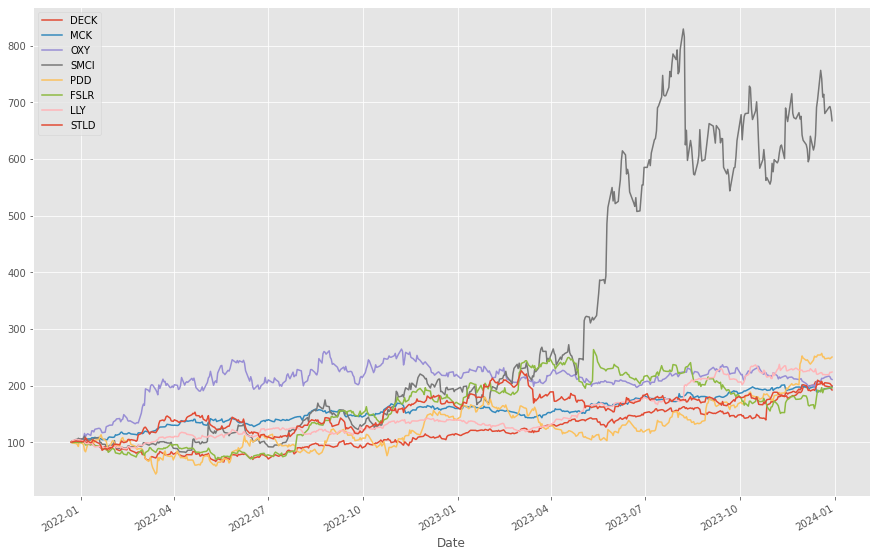

In [91]:
if plot_:
    (100 * df/df.iloc[0]).plot(figsize=(15, 10), legend=True)

# VaR

In [92]:
def calc_portfolio_perf_VaR(weights, returns, cov, alpha):
    portfolio_return = weights.T @ returns.mean() 
    portfolio_std = np.sqrt(weights.T @ cov @ weights)
    portfolio_var_histo = abs(np.percentile(returns @ weights.T, alpha*100))
    portfolio_var_param = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_return, portfolio_var_histo, portfolio_var_param

def simulate_random_portfolios_VaR(num_portfolios, returns, cov, alpha, days):
    n_asset = len(returns.columns)
    results_matrix = np.ones((n_asset+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(n_asset)
        weights /= np.sum(weights)
        portfolio_return, portfolio_VaR_histo, portfolio_VaR_param  = calc_portfolio_perf_VaR(weights, returns, cov, alpha)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_VaR_histo
        results_matrix[2,i] = portfolio_VaR_param
        results_matrix[3:,i] *= weights
            
    results_df = pd.DataFrame(results_matrix.T,columns=['Return','VaR Histo','VaR Param'] + [ticker for ticker in tickers])
        
    return results_df

def obj_min_historical_var(weights, returns, alpha=0.05):
    portfolio_returns = np.dot(returns, weights)
    sorted_returns = np.sort(portfolio_returns)
    var_index = int(alpha * len(sorted_returns))
    var = abs(sorted_returns[var_index])
    return var

def obj_min_param_var(weights, returns, alpha=0.05):
    portfolio_mean = np.dot(weights, returns.mean())
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
    var = abs(portfolio_mean - portfolio_std * stats.norm.ppf(1 - alpha))
    return var

def min_VaR(returns, cov, which):
    num_assets = len(returns.columns)
    args = (returns,)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.,1)
    bounds = tuple(bound for asset in range(num_assets))
    if which == "Parametric":
        result = minimize(obj_min_param_var, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    elif which == "Historical":
        result = minimize(obj_min_historical_var, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

In [93]:
returns = df.pct_change().dropna()
cov = returns.cov()
num_portfolios = 1000
days = 252
alpha = 0.05
sim_portfolio_VaR = simulate_random_portfolios_VaR(num_portfolios, returns, cov, alpha, days)
sim_portfolio_VaR

,Return,VaR Histo,VaR Param,DECK,MCK,OXY,SMCI,PDD,FSLR,LLY,STLD
0,0.002637,0.028077,0.028768,0.020418,0.121928,0.183646,0.206609,0.200839,0.084900,0.179665,0.001995
1,0.002596,0.027851,0.029561,0.157352,0.012013,0.000989,0.254265,0.073428,0.170600,0.239693,0.091659
2,0.002424,0.024350,0.026391,0.015594,0.109954,0.031231,0.174555,0.126945,0.158500,0.212502,0.170719
3,0.002541,0.027298,0.029310,0.103952,0.094048,0.184998,0.236669,0.063201,0.245693,0.046812,0.024626
4,0.002344,0.023356,0.024064,0.008178,0.219035,0.044520,0.203480,0.028288,0.197702,0.213396,0.085401
...,...,...,...,...,...,...,...,...,...,...,...
995,0.002129,0.023919,0.025419,0.110103,0.083233,0.223990,0.060816,0.157828,0.005984,0.162899,0.195148
996,0.002429,0.026439,0.028532,0.176904,0.008864,0.236190,0.224664,0.001939,0.183741,0.103360,0.064338
997,0.002474,0.028668,0.029707,0.070363,0.062202,0.212390,0.146951,0.196584,0.156423,0.088251,0.066836
998,0.002028,0.024462,0.025796,0.225764,0.106561,0.286135,0.039542,0.138553,0.020723,0.070573,0.112149


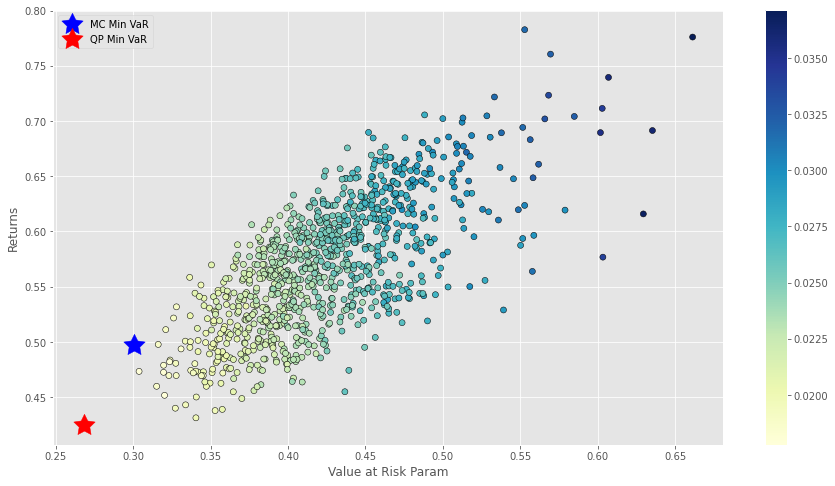

In [94]:
min_VaR_port_param_qp = min_VaR(returns, cov, "Parametric")
min_VaR_port_param = sim_portfolio_VaR.iloc[sim_portfolio_VaR['VaR Param'].idxmin()]
plt.figure(figsize=(15, 8))
plt.scatter(sim_portfolio_VaR['VaR Param'] * np.sqrt(days), sim_portfolio_VaR['Return'] * days,c=sim_portfolio_VaR['VaR Histo'],edgecolors="black",cmap='YlGnBu')
plt.colorbar()
plt.scatter(min_VaR_port_param[2] * np.sqrt(days),min_VaR_port_param[0] * days,marker=(5,1,0),color='b',s=500, label="MC Min VaR")
plt.scatter(obj_min_param_var(min_VaR_port_param_qp * np.sqrt(days), returns, alpha=0.05), (min_VaR_port_param_qp @ returns.mean().T) * days, marker=(5,1,0), color='r', s=500, label="QP Min VaR")
plt.xlabel('Value at Risk Param')
plt.ylabel('Returns')
plt.legend()

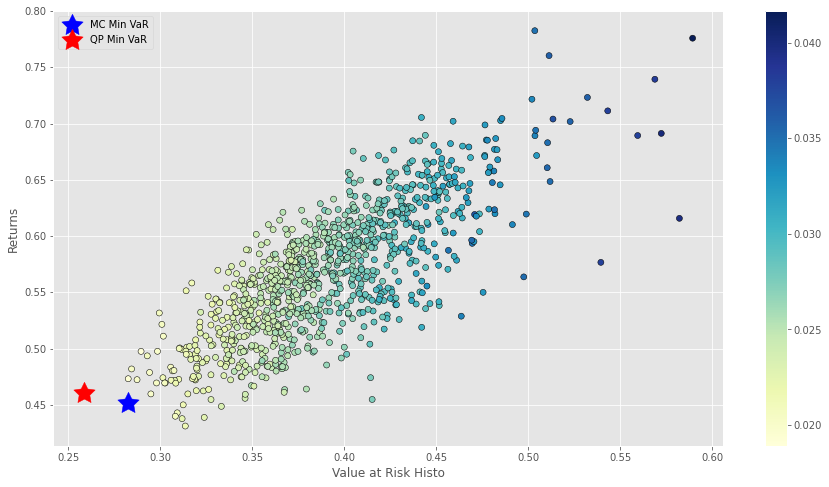

In [95]:
min_VaR_port_histo_qp = min_VaR(returns, cov, "Historical")
min_VaR_port_histo = sim_portfolio_VaR.iloc[sim_portfolio_VaR['VaR Histo'].idxmin()]
plt.figure(figsize=(15, 8))
plt.scatter(sim_portfolio_VaR['VaR Histo'] * np.sqrt(days), sim_portfolio_VaR['Return'] * days,c=sim_portfolio_VaR['VaR Param'],edgecolors="black",cmap='YlGnBu')
plt.colorbar()
plt.scatter(min_VaR_port_histo[1] * np.sqrt(days), min_VaR_port_histo[0] * days,marker=(5,1,0),color='b',s=500, label="MC Min VaR")
plt.scatter(obj_min_historical_var(min_VaR_port_histo_qp, returns, alpha=0.05) * np.sqrt(days), (min_VaR_port_histo_qp @ returns.mean().T) * days, marker=(5,1,0), color='r', s=500, label="QP Min VaR")
plt.xlabel('Value at Risk Histo')
plt.ylabel('Returns')
plt.legend()

In [96]:
if country == "US":
    bench_ticker = "^GSPC"
elif country == "FR":
    bench_ticker = "^FCHI"
benchmark_returns = yf.download(bench_ticker, start, end)['Adj Close'].pct_change().dropna()
bench_port = 100 * (1 + benchmark_returns).cumprod()
equal_weigth_port = 100 * (1 + (returns @ np.ones(len(tickers))/len(tickers))).cumprod()
min_VaR_histo_port = 100 * (1 + (returns @ sim_portfolio_VaR.iloc[sim_portfolio_VaR['VaR Histo'].idxmin()].iloc[3:].T)).cumprod()
min_VaR_param_port = 100 * (1 + (returns @ sim_portfolio_VaR.iloc[sim_portfolio_VaR['VaR Param'].idxmin()].iloc[3:].T)).cumprod()
min_VaR_histo_port_qp_equity = 100 * (1 + (returns @ min_VaR_port_histo_qp.T)).cumprod()
min_VaR_param_port_qp_equity = 100 * (1 + (returns @ min_VaR_port_param_qp.T)).cumprod()

[*********************100%***********************]  1 of 1 completed


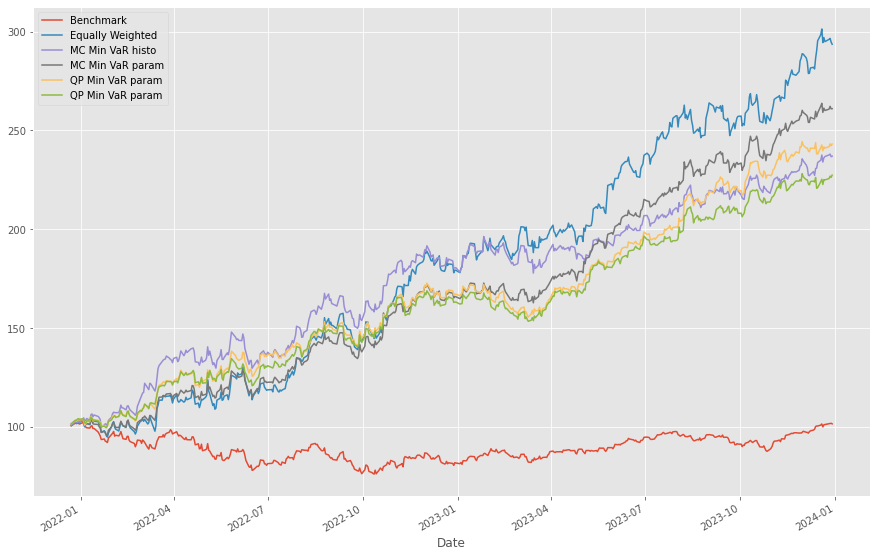

In [97]:
plt.figure(figsize=(15, 10))
bench_port.plot(label="Benchmark")
equal_weigth_port.plot(label="Equally Weighted")
min_VaR_histo_port.plot(label="MC Min VaR histo")
min_VaR_param_port.plot(label="MC Min VaR param")
min_VaR_histo_port_qp_equity.plot(label="QP Min VaR param")
min_VaR_param_port_qp_equity.plot(label="QP Min VaR param")
plt.legend()

In [98]:
if country == "US":
    bench_ticker = "^GSPC"
elif country == "FR":
    bench_ticker = "^FCHI"
benchmark_returns_test = yf.download(bench_ticker, end)['Adj Close'].pct_change().dropna()
returns_test = yf.download(tickers, end)['Adj Close'].pct_change().dropna()
bench_port_test = 100 * (1 + benchmark_returns_test).cumprod()
equal_weigth_port_test = 100 * (1 + (returns_test @ np.ones(len(tickers))/len(tickers))).cumprod()
min_VaR_histo_port_test = 100 * (1 + (returns_test @ sim_portfolio_VaR.iloc[sim_portfolio_VaR['VaR Histo'].idxmin()].iloc[3:].T)).cumprod()
min_VaR_param_port_test = 100 * (1 + (returns_test @ sim_portfolio_VaR.iloc[sim_portfolio_VaR['VaR Param'].idxmin()].iloc[3:].T)).cumprod()
min_VaR_histo_port_qp_equity_test = 100 * (1 + (returns_test @ min_VaR_port_histo_qp.T)).cumprod()
min_VaR_param_port_qp_equity_tes = 100 * (1 + (returns_test @ min_VaR_port_param_qp.T)).cumprod()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  8 of 8 completed


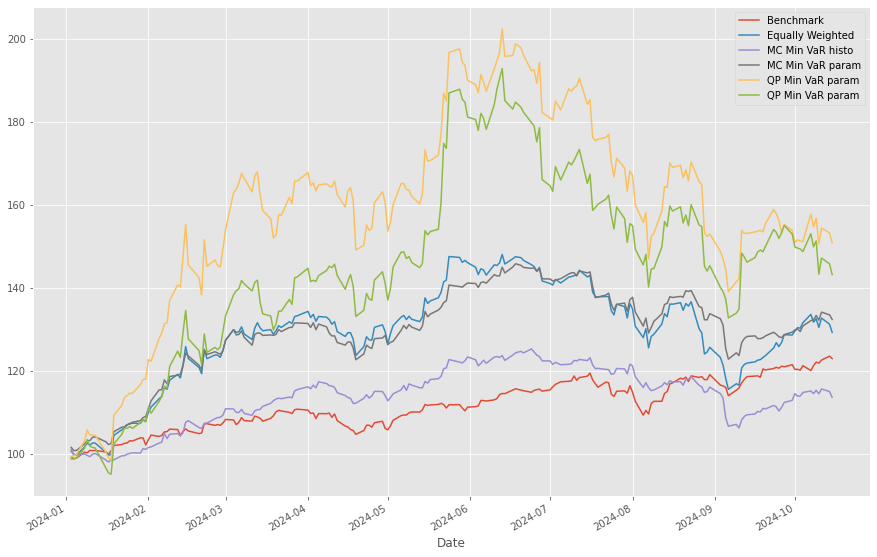

In [99]:
plt.figure(figsize=(15, 10))
bench_port_test.plot(label="Benchmark")
equal_weigth_port_test.plot(label="Equally Weighted")
min_VaR_histo_port_test.plot(label="MC Min VaR histo")
min_VaR_param_port_test.plot(label="MC Min VaR param")
min_VaR_histo_port_qp_equity_test.plot(label="QP Min VaR param")
min_VaR_param_port_qp_equity_tes.plot(label="QP Min VaR param")
plt.legend()

# Mean-Variance / Sharpe Ratio Optimization

In [100]:
num_portfolios = 10000
days = 255
rf = 0.01

In [101]:
return_estimation_method = "Historical"
variance_estimation_method = "Historical"

### Monte Carlo version

In [102]:
def return_estimations(method, returns, days):
    if method == "Historical":
        returns_res = returns.mean()
    return returns_res * days

def cov_estimation(method, returns, days):
    if method == "Historical":
        cov_res = returns.cov()
    return cov_res * days

def simulate_random_portfolios_mean_variance(num_portfolios, returns, rf, method="Historical"):
    n_asset = len(returns.columns)
    results_matrix = np.ones((n_asset+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(n_asset)
        weights /= np.sum(weights)
        portfolio_return = (weights @ return_estimations(method, returns, days).T)
        portfolio_variance = (weights.T @ cov_estimation(method, returns, days) @ weights)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = np.sqrt(portfolio_variance)
        results_matrix[2,i] = (portfolio_return - rf) / portfolio_variance
        results_matrix[3:,i] *= weights
            
    results_df = pd.DataFrame(results_matrix.T,columns=['Return','Std', "Sharpe Ratio"] + [ticker for ticker in tickers])
        
    return results_df

In [103]:
df_sim_min_var = simulate_random_portfolios_mean_variance(num_portfolios, returns, rf, method="Historical")
df_sim_min_var

,Return,Std,Sharpe Ratio,DECK,MCK,OXY,SMCI,PDD,FSLR,LLY,STLD
0,0.636919,0.296957,7.109277,0.189597,0.033748,0.206759,0.186615,0.148092,0.015296,0.159461,0.060433
1,0.588400,0.269888,7.940743,0.139814,0.102201,0.180243,0.163041,0.068398,0.142621,0.090232,0.113450
2,0.555659,0.276731,7.125324,0.027560,0.034306,0.205380,0.069003,0.140735,0.211528,0.193766,0.117723
3,0.530281,0.285361,6.389230,0.206530,0.117542,0.039633,0.027727,0.208261,0.102725,0.196095,0.101486
4,0.672598,0.310278,6.882547,0.046361,0.167006,0.126452,0.204408,0.227801,0.017718,0.167816,0.042439
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.577403,0.250563,9.037714,0.103603,0.105385,0.172086,0.169731,0.018889,0.165242,0.236296,0.028768
9996,0.600758,0.280386,7.514453,0.030015,0.098719,0.072338,0.194680,0.031882,0.210594,0.159702,0.202070
9997,0.659681,0.318433,6.407154,0.056598,0.023857,0.130650,0.193858,0.173418,0.188146,0.144375,0.089097
9998,0.667996,0.310607,6.820276,0.003139,0.023892,0.196555,0.197046,0.189632,0.080230,0.197712,0.111793


### QP version

In [104]:
def obj_portfolio_return(w, mean_returns, cov):
    portfolio_return = w @ mean_returns.T
    return -portfolio_return

def obj_portfolio_std(w, mean_returns, cov):
    portfolio_std = np.sqrt(w.T @ cov @ w)
    return portfolio_std

def obj_sharpe_ratio(w, mean_returns, cov, rf):
    return -((w.T @ mean_returns) - rf)/ np.sqrt(w @ cov @ w.T)

def min_variance(mean_returns, cov):
    num_assets = len(mean_returns)
    args = (mean_returns, cov)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.,1.)
    bounds = tuple(bound for asset in range(num_assets))
    result = minimize(obj_portfolio_std, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def max_return(mean_returns, cov, target_risk):
    num_assets = len(mean_returns)
    args = (mean_returns, cov)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                  {'type': 'eq', 'fun': lambda x: obj_portfolio_std(x, mean_returns, cov) - target_risk})
    bound = (0.,1.)
    bounds = tuple(bound for asset in range(num_assets))
    result = minimize(obj_portfolio_return, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def max_sharpe_ratio(mean_returns, cov, rf):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, rf)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.,1)
    bounds = tuple(bound for asset in range(num_assets))
    result = minimize(obj_sharpe_ratio, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

In [105]:
mean_returns = return_estimations(return_estimation_method, returns, days)
cov_returns = cov_estimation(variance_estimation_method, returns, days)
rf = 0.05
min_port_variance = min_variance(mean_returns, cov_returns)
max_sharpe_ratio_port = max_sharpe_ratio(mean_returns, cov_returns, rf)

efficient_frontier = []
max_var, min_var = max(df_sim_min_var['Std']), np.sqrt(min_port_variance.T @ cov_returns @ min_port_variance)
target_risks = np.linspace(min_var, max_var, 50)
efficient_frontier_weights = []
for i in tqdm(range(len(target_risks)), desc="Efficient Frontier Construction"):
    w_eff_fr = max_return(mean_returns, cov_returns, target_risks[i])
    efficient_frontier.append((target_risks[i], w_eff_fr @ mean_returns.T))
    efficient_frontier_weights.append(w_eff_fr)

Efficient Frontier Construction: 100%|██████████| 50/50 [00:00<00:00, 62.65it/s]


### Visualization

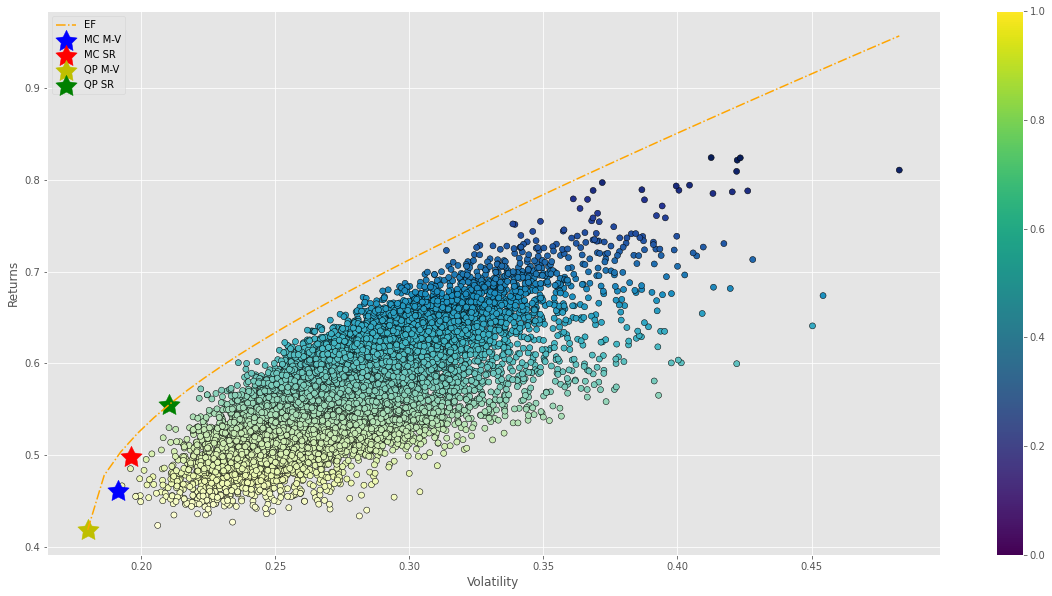

In [106]:
mean_variance_port_monte_carlo = df_sim_min_var.iloc[df_sim_min_var['Std'].idxmin()]
sharpe_ratio_port_monte_carlo = df_sim_min_var.iloc[df_sim_min_var['Sharpe Ratio'].idxmax()]
plt.figure(figsize=(20,10))
plt.plot([x[0] for x in efficient_frontier], [x[1] for x in efficient_frontier], color="orange", ls='-.', label="EF")
plt.scatter(df_sim_min_var.Std, df_sim_min_var.Return,c=df_sim_min_var.Return, edgecolors="black", cmap='YlGnBu')
plt.scatter(mean_variance_port_monte_carlo[1], mean_variance_port_monte_carlo[0], marker=(5,1,0), color='b',s=500, label="MC M-V")
plt.scatter(sharpe_ratio_port_monte_carlo[1], sharpe_ratio_port_monte_carlo[0], marker=(5,1,0), color='r',s=500, label="MC SR")
plt.scatter(np.sqrt(min_port_variance.T @ cov_returns @ min_port_variance), min_port_variance @ mean_returns.T, marker=(5,1,0), color='y', s=500, label="QP M-V")
plt.scatter(np.sqrt(max_sharpe_ratio_port.T @ cov_returns @ max_sharpe_ratio_port), max_sharpe_ratio_port @ mean_returns.T, marker=(5,1,0), color='g', s=500, label="QP SR")
plt.colorbar()
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.legend()

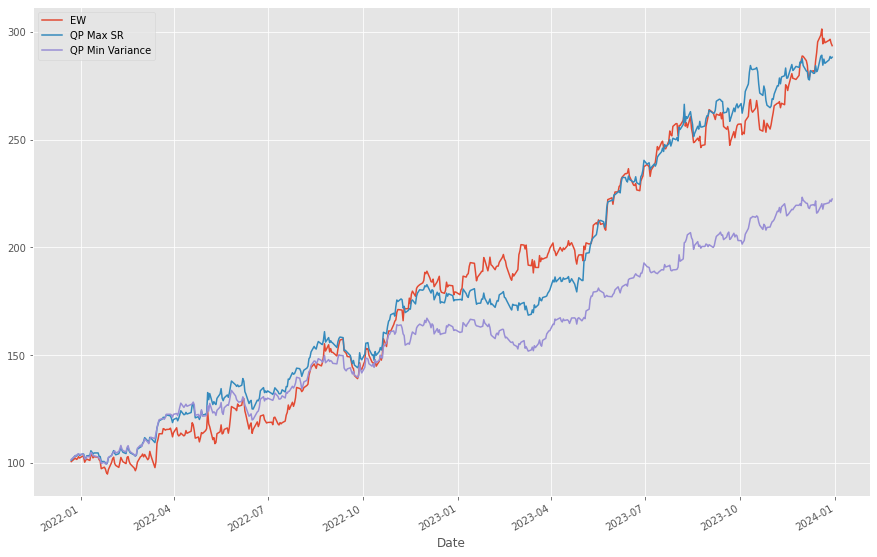

In [107]:
plt.figure(figsize=(15, 10))
(100 * (1 + returns @ (np.ones(n_assets)*1/n_assets).T).cumprod()).plot(label="EW")
(100 * (1 + returns @ max_sharpe_ratio_port.T).cumprod()).plot(label="QP Max SR")
(100 * (1 + returns @ min_port_variance.T).cumprod()).plot(label="QP Min Variance")
plt.legend()

## TEST

In [108]:
risk_grades = pd.DataFrame(np.round(efficient_frontier, 3), columns=["Volatility", "Return"])
risk_grades

,Volatility,Return
0,0.180,0.419
1,0.186,0.478
2,0.192,0.504
3,0.199,0.524
4,0.205,0.541
5,0.211,0.556
6,0.217,0.571
7,0.223,0.584
8,0.230,0.596
9,0.236,0.608


In [109]:
target_risk = risk_grades.iloc[5, 0]
target_risk

0.211

In [110]:
df_test = yf.download(tickers, end)['Adj Close']
returns_test = df_test.pct_change().dropna()
if country == "US":
    bench_ticker = "^GSPC"
elif country == "FR":
    bench_ticker = "^FCHI"
benchmark_returns = yf.download(bench_ticker, end)['Adj Close'].pct_change().dropna()

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  1 of 1 completed


In [111]:
returns_test = df_test.pct_change().dropna()

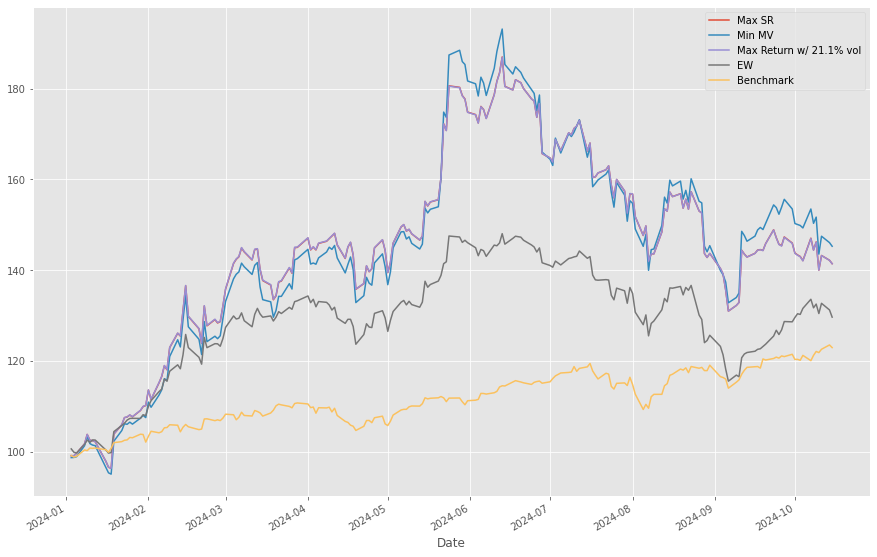

In [112]:
plt.figure(figsize=(15, 10))
(100 * (1 + returns_test @ max_sharpe_ratio_port.T).cumprod()).plot(label="Max SR")
(100 * (1 + returns_test @ min_port_variance.T).cumprod()).plot(label="Min MV")
(100 * (1 + returns_test @ efficient_frontier_weights[5].T).cumprod()).plot(label=f"Max Return w/ {round(target_risk*100, 3)}% vol")
(100 * (1 + returns_test @ (np.ones(n_assets)*1/n_assets).T).cumprod()).plot(label="EW")
(100 * (1 + benchmark_returns).cumprod()).plot(label="Benchmark")
plt.legend()